In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Concatenate, Reshape, Add, UpSampling2D, MaxPool2D
from tensorflow.keras.layers import Flatten, ReLU, LeakyReLU, PReLU, Embedding, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.initializers import RandomNormal
from tqdm import tqdm
from IPython import display

In [2]:
tf.config.experimental_run_functions_eagerly(True)

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
original_image_shape = (54, 44, 3)
target_image_shape = (216, 176, 3)

## Load Data

In [5]:
hr_image_path = './data/preprocessed_celeb/high_resolution/'
lr_image_path = './data/preprocessed_celeb/low_resolution/'

def load_data():
    hr = []
    lr = []
    for i in range(1,5001):
        x = cv.imread(f'{hr_image_path}{i}.jpg')
        y = cv.imread(f'{lr_image_path}{i}.jpg')
        x = cv.cvtColor(x, cv.COLOR_BGR2RGB)
        y = cv.cvtColor(y, cv.COLOR_BGR2RGB)
        hr.append(x)
        lr.append(y)
    return np.array(hr), np.array(lr)

In [6]:
hr, lr = load_data()
x_train, x_test = lr[:4800]/255, lr[4800:]/255
y_train, y_test = hr[:4800]/255, hr[4800:]/255

In [7]:
def generator(shape):
    
    def down_sampling(filters, kernel_size):        
        def _down_sampling(input_layer):
            # conv,bn,relu,conv,bn,add
            conv1 = Conv2D(filters, kernel_size, padding='same', 
                           kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(input_layer)
            bn1 = BatchNormalization(momentum = 0.5)(conv1)
            relu = PReLU(alpha_initializer='zeros', alpha_regularizer=None, 
                         alpha_constraint=None, shared_axes=[1,2])(bn1)
            conv2 = Conv2D(filters, kernel_size, padding='same',
                           kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(relu)
            bn2 = BatchNormalization(momentum = 0.5)(conv2)
            add = Add()([bn2,input_layer])
            return add
        return _down_sampling
    
    def up_sampling(filters, kernel_size):        
        def _up_sampling(input_layer):
            # conv,deconv*2,lrelu
            conv1 = Conv2D(filters, kernel_size, padding='same',
                         kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(input_layer)
            up = UpSampling2D(2)(conv1)
            conv2 = Conv2D(filters, kernel_size, padding='same',
                         kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(up)
            
#             deconv1 = Conv2DTranspose(filters, kernel_size, padding='same', strides=(2,2),
#                                       kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(conv)
#             deconv2 = Conv2DTranspose(filters, kernel_size, padding='same',
#                                       kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(deconv1)
            lrelu = LeakyReLU(0.2)(conv2)
            return lrelu
        return _up_sampling
    
    gen_input = Input(shape)
    
    conv1 = Conv2D(64, 9, padding='same')(gen_input)
    lrelu = PReLU(alpha_initializer='zeros', alpha_regularizer=None, 
                  alpha_constraint=None, shared_axes=[1,2])(conv1) # add
    down1 = down_sampling(64,3)(lrelu)
    down2 = down_sampling(64,3)(down1)
    down3 = down_sampling(64,3)(down2)
    down4 = down_sampling(64,3)(down3)
    conv2 = Conv2D(64,3, padding='same')(down2)
    bn = BatchNormalization(momentum = 0.5)(conv2)
    add = Add()([bn,lrelu])
#     concat = Concatenate()([bn,lrelu])
    up1 = up_sampling(256,3)(add)
    up2 = up_sampling(256,3)(up1)
    conv3 = Conv2D(3,9, padding='same', activation='tanh')(up2)
    
    model = Model(inputs=gen_input, outputs=conv3)
    
    return model

In [8]:
def discriminator(shape):
    
    def conv_block(filters, kernel_size, strides, padding):
        def _conv_block(input_layer):
            conv = Conv2D(filters, kernel_size, strides, padding=padding,
                         kernel_initializer = RandomNormal(mean=0.0, stddev = 0.02))(input_layer)
            bn = BatchNormalization(momentum = 0.5)(conv)
            lrelu = LeakyReLU(0.2)(bn)
            return lrelu
        return _conv_block
    
    dis_input = Input(shape)
    
    conv = Conv2D(32, 3, padding='same')(dis_input)
    lrelu1 = LeakyReLU(0.2)(conv)
    conv1 = conv_block(32,3,2,'same')(lrelu1)
    conv2 = conv_block(64,3,1,'same')(conv1)
    conv3 = conv_block(64,3,2,'same')(conv2)
    conv4 = conv_block(128,3,1,'same')(conv3)
    conv5 = conv_block(128,3,2,'same')(conv4)
    conv6 = conv_block(256,3,1,'same')(conv5)
    conv7 = conv_block(256,3,2,'same')(conv6)
    # Dense vs global average pool
#     flat = Flatten()(conv7)
#     fcn1 = Dense(512)(flat)
    pool = GlobalAveragePooling2D()(conv7)
    lrelu1 = LeakyReLU(0.2)(pool)
    
    fcn2 = Dense(1, activation='sigmoid')(lrelu1)
    
    model = Model(inputs=dis_input, outputs=fcn2)
    
    return model

In [9]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
net = MobileNetV2(input_shape=target_image_shape,include_top=False, weights='imagenet')
def content_loss(hr_images, sr_images):
    net.trainable=False
    for i in net.layers:
        i.trainable=False
    model = Model(inputs=net.input,outputs=net.get_layer('block_4_expand').output)
    model.trainable=False
    loss = tf.losses.mse(model(hr_images), model(sr_images))
    return loss

In [10]:
def define_gan(g_model, d_model, image_shape, loss, optimizer):
    # make weights in the discriminator not trainable
    d_model.trainable = False

    lr_images = Input(shape=image_shape)
    
    sr_images = g_model(lr_images)
    dis_out = d_model(sr_images)
    
    model = Model(lr_images, [sr_images, dis_out])
    
    model.compile(loss=[loss, 'binary_crossentropy'], optimizer=optimizer, loss_weights=[1.,1e-3])

    return model

In [11]:
def generate_and_save_image(epoch, x_test, gen): ### comparison
    
    display.clear_output(wait=True)
    prediction = gen(x_test[:16], training = False)
    prediction = prediction.numpy()

    fig = plt.figure(figsize=(10,10))

    for j in range(16):
        plt.subplot(4, 4, j+1)
        plt.imshow((prediction[j]*255).astype('int32'))
        plt.axis("off")
    plt.savefig(f'./SRGAN_x4/fig/epoch_{epoch}.png')
    plt.show()

In [12]:
optimizer = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

gen = generator(original_image_shape)
gen.compile(loss=content_loss, optimizer=optimizer)

dis = discriminator(target_image_shape)
dis.compile(loss='binary_crossentropy', optimizer=optimizer, loss_weights=[0.5])

gan = define_gan(gen, dis, original_image_shape, content_loss, optimizer)


def train(n_epochs, gen, dis, gan, batch_size=16):

    batch_count = int(x_train.shape[0] // batch_size)
    

    
    for e in range(1, n_epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            
            rand_nums = np.random.randint(0, x_train.shape[0], size=batch_size)
            
            image_batch_lr = x_train[rand_nums]
            image_batch_hr = y_train[rand_nums]
            generated_images_sr = gen.predict(image_batch_lr)

            real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            fake_data_Y = np.random.random_sample(batch_size)*0.2
            
            dis.trainable = True
            
            d_loss_real = dis.train_on_batch(image_batch_hr, real_data_Y)
            d_loss_fake = dis.train_on_batch(generated_images_sr, fake_data_Y)
            discriminator_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
            
            rand_nums = np.random.randint(0, x_train.shape[0], size=batch_size)
            image_batch_lr = x_train[rand_nums]
            image_batch_hr = y_train[rand_nums]

            gan_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            dis.trainable = False
            gan_loss = gan.train_on_batch(image_batch_lr, [image_batch_hr,gan_Y])
            
    
        if e == 1 or e % 5 == 0:
            generate_and_save_image(e, x_test, gen)
        if e % 10 == 0:
            gen.save(f'./SRGAN_x4/model/gen_model{e}.h5')
            dis.save(f'./SRGAN_x4/model/dis_model{e}.h5')
            
            
        print("discriminator_loss : %f" % discriminator_loss)
        print("gan_loss :", gan_loss)

In [13]:
model_path = './SRGAN_x4/model/'
fig_path = './SRGAN_x4/fig/'
if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

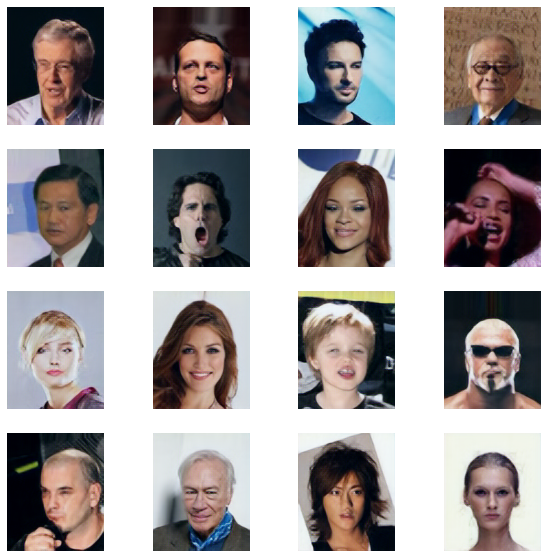

discriminator_loss : 0.176085
gan_loss : [0.38525643944740295, 0.38450223207473755, 0.7542045712471008]


In [14]:
train(100, gen, dis, gan, batch_size=16)